# **Trabalho 2 - Introdução ao Aprendizado de Máquina (EEL891)**
### Regressão Multivariável: estimar o preço de um imóvel a partir de suas características

---

**Aluno:** Danilo Davi Gomes Fróes

**DRE:** 124026825

**Usuário Kaggle:** *dgfroes*

**Semestre:** 2025.01

---

### **1. Introdução e Objetivo**

Este notebook documenta o processo de desenvolvimento de um modelo de regressão para o segundo trabalho da disciplina EEL891. O objetivo central é estimar o preço de venda de imóveis a partir de um conjunto de características, como tipo, bairro, área e comodidades.

A abordagem seguirá as melhores práticas de um projeto de Machine Learning, incluindo uma análise exploratória de dados (EDA) aprofundada, engenharia de features, otimização de hiperparâmetros e a construção de um modelo de ensemble robusto. O sucesso do projeto será medido pela métrica **Root Mean Square Percentage Error (RMSPE)**, que guiará nossas decisões de modelagem.

Abaixo temos a primeira célula de código em Python, abrindo as configurações iniciais do nosso código com a importação de bibliotecas e definição de itens.

In [66]:
# Célula de importação de bibliotecas

# Bibliotecas de manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Pré-processamento e Validação
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

# Modelos
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Métricas
from sklearn.metrics import make_scorer

# Remoção de avisos para evitar poluição visual
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

### **2. Análise Exploratória de Dados (EDA)**

Essa é uma parte essencial para o entendimento dos dados e a busca para melhores soluções para o modelo. A análise será feita com base no dicionário disponibilizado na página de dados do trabalho no Kaggle e no uso de funções da biblioteca pandas para detalhamento de datasets.

In [67]:
df_treinamento_raw = pd.read_csv('conjunto_de_treinamento_reg.csv')
df_teste_raw = pd.read_csv('conjunto_de_teste_reg.csv')

print(f"Info treinamento: {df_treinamento_raw.info()}")
display(df_treinamento_raw.describe())
print(f"Info teste: {df_teste_raw.info()}")
display(df_teste_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4683 entries, 0 to 4682
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              4683 non-null   int64  
 1   tipo            4683 non-null   object 
 2   bairro          4683 non-null   object 
 3   tipo_vendedor   4683 non-null   object 
 4   quartos         4683 non-null   int64  
 5   suites          4683 non-null   int64  
 6   vagas           4683 non-null   int64  
 7   area_util       4683 non-null   int64  
 8   area_extra      4683 non-null   int64  
 9   diferenciais    4683 non-null   object 
 10  churrasqueira   4683 non-null   int64  
 11  estacionamento  4683 non-null   int64  
 12  piscina         4683 non-null   int64  
 13  playground      4683 non-null   int64  
 14  quadra          4683 non-null   int64  
 15  s_festas        4683 non-null   int64  
 16  s_jogos         4683 non-null   int64  
 17  s_ginastica     4683 non-null   i

,Id,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
count,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4.683000e+03
mean,4341.000000,3.043562,1.434337,1.708093,124.158018,13.293188,0.316891,0.030750,0.555627,0.157378,0.039078,0.138159,0.006833,0.013666,0.096306,0.027333,9.277053e+05
std,1352.009985,0.873590,1.102457,1.210975,107.365110,266.803756,0.465314,0.172657,0.496949,0.364195,0.193800,0.345104,0.082389,0.116114,0.295042,0.163069,1.050607e+07
min,2000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000e+02
25%,3170.500000,3.000000,1.000000,1.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.550000e+05
50%,4341.000000,3.000000,1.000000,2.000000,96.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.150000e+05
75%,5511.500000,4.000000,2.000000,2.000000,149.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.300000e+05
max,6682.000000,9.000000,6.000000,30.000000,2045.000000,17450.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.300000e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              2000 non-null   int64 
 1   tipo            2000 non-null   object
 2   bairro          2000 non-null   object
 3   tipo_vendedor   2000 non-null   object
 4   quartos         2000 non-null   int64 
 5   suites          2000 non-null   int64 
 6   vagas           2000 non-null   int64 
 7   area_util       2000 non-null   int64 
 8   area_extra      2000 non-null   int64 
 9   diferenciais    2000 non-null   object
 10  churrasqueira   2000 non-null   int64 
 11  estacionamento  2000 non-null   int64 
 12  piscina         2000 non-null   int64 
 13  playground      2000 non-null   int64 
 14  quadra          2000 non-null   int64 
 15  s_festas        2000 non-null   int64 
 16  s_jogos         2000 non-null   int64 
 17  s_ginastica     2000 non-null   int64 
 18  sauna   

,Id,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,3.093000,1.514500,1.778500,126.94200,21.063500,0.312000,0.030500,0.565500,0.164500,0.043000,0.139500,0.006000,0.015000,0.097500,0.030500
std,577.494589,0.889239,1.141684,1.215803,105.58097,317.044762,0.463426,0.172002,0.495815,0.370821,0.202908,0.346554,0.077246,0.121583,0.296712,0.172002
min,0.000000,1.000000,0.000000,0.000000,16.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,499.750000,3.000000,1.000000,1.000000,70.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,999.500000,3.000000,1.000000,2.000000,100.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1499.250000,4.000000,2.000000,2.000000,153.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1999.000000,10.000000,6.000000,30.000000,2735.00000,12060.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### **3. Análise da Variável Alvo (`preco`) e Definição da Métrica**

A etapa mais crucial em um problema de regressão é entender a natureza da variável alvo.

#### 3.1. Distribuição e Transformação Logarítmica

O histograma da variável `preco` revela uma forte **assimetria positiva** (*right-skewed*), com uma grande concentração de imóveis em faixas de preço mais baixas e uma cauda longa de imóveis de altíssimo valor. Essa característica é problemática para muitos algoritmos de regressão, pois os valores extremos (outliers) podem influenciar desproporcionalmente o treinamento, e a violação da premissa de normalidade dos resíduos pode degradar a performance do modelo.

A solução padrão e mais eficaz para este cenário é a **transformação logarítmica**. Aplicamos a função $y_{log} = \log(1 + y_{original})$ para normalizar a distribuição. O uso de `log1p` (equivalente a $\log(1+x)$) é uma prática robusta que garante validade matemática mesmo que existam valores nulos (preço = 0).

Como o segundo gráfico demonstra, a aplicação da transformação resulta em uma distribuição muito mais simétrica e próxima de uma distribuição Gaussiana. Isso estabiliza a variância e melhora a performance e a convergência da maioria dos algoritmos de regressão. Nosso modelo será treinado para prever o `log(preco)`, e a transformação inversa (exponencial, $e^x - 1$) será aplicada na predição final.

#### 3.2. Métrica de Avaliação: RMSPE

A métrica de avaliação definida para a competição é a **Raiz Quadrada do Erro Percentual Quadrático Médio (RMSPE)**. Sua fórmula é:

$$ \text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \frac{y_i - \hat{y}_i}{y_i} \right)^2} $$

Onde:
- $n$ é o número de amostras.
- $y_i$ é o preço real do imóvel $i$.
- $\hat{y}_i$ é o preço previsto para o imóvel $i$.

Diferente do RMSE (Root Mean Squared Error), o RMSPE mede o erro em termos **percentuais**, pois a diferença $(y_i - \hat{y}_i)$ é normalizada pelo valor real $y_i$. Isso significa que um erro de R$20.000 em um imóvel de R$200.000 (erro de 10%) é penalizado muito mais do que o mesmo erro de R$20.000 em um imóvel de R$2.000.000 (erro de 1%). A métrica, portanto, valoriza a precisão do modelo especialmente nas faixas de preço mais baixas.

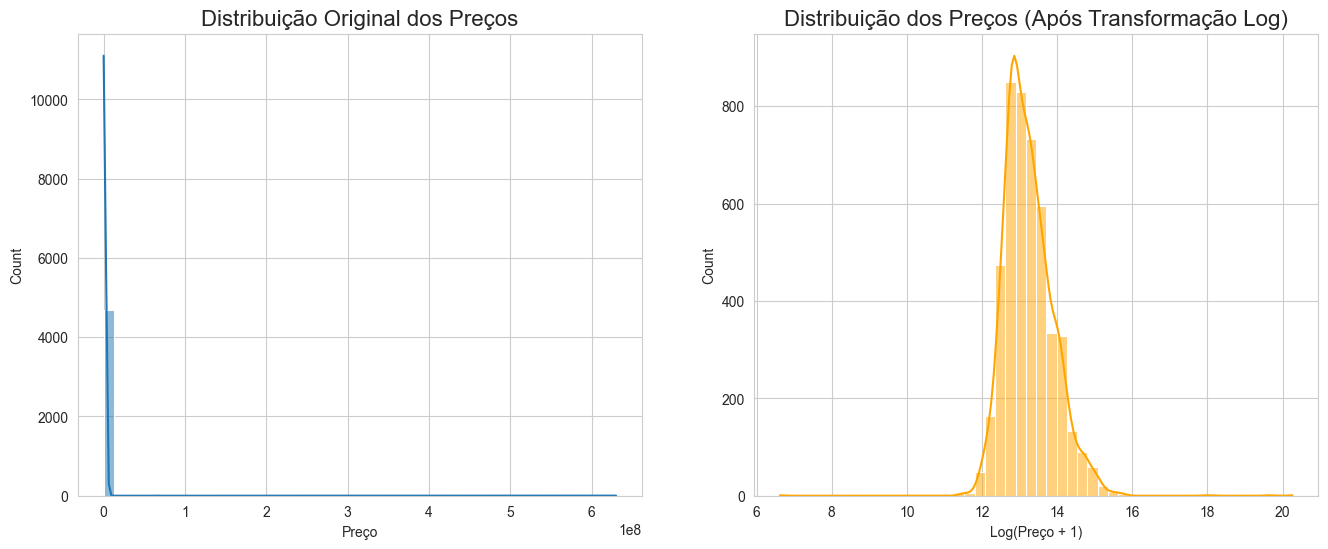

In [68]:
# Gráficos da distribuição do preço
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_treinamento_raw['preco'], kde=True, bins=50)
plt.title('Distribuição Original dos Preços', fontsize=16)
plt.xlabel('Preço')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_treinamento_raw['preco']), kde=True, bins=50, color='orange')
plt.title('Distribuição dos Preços (Após Transformação Log)', fontsize=16)
plt.xlabel('Log(Preço + 1)')
plt.show()

# Definição da Métrica Customizada (RMSPE)
def rmspe(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    percentage_error = (y_true - y_pred) / y_true
    return np.sqrt(np.mean(np.square(percentage_error)))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

### **4. Engenharia de Dados**
Dados brutos raramente estão em um formato ótimo para a modelagem. Esta etapa fundamental consiste em limpar, transformar e enriquecer o dataset para extrair o máximo de informação preditiva, preparando o terreno para que os algoritmos de machine learning performem com máxima eficácia.

Todo o processo foi encapsulado em uma única função, `processar_features`, para garantir que as mesmas transformações fossem aplicadas de forma idêntica e consistente tanto ao conjunto de treino quanto ao de teste. A premissa central para evitar o vazamento de dados (*data leakage*) foi respeitada: toda e qualquer estatística de ajuste (medianas, médias, etc.) foi calculada **exclusivamente** a partir do conjunto de treino e, em seguida, aplicada a ambos os conjuntos.

#### 4.1. Tratamento de Dados

A primeira fase consistiu em garantir a qualidade e a consistência dos dados.

* **Correções Lógicas:** Foram aplicadas duas correções de consistência:
    1.  Imóveis com `area_util` igual a zero foram tratados como dados faltantes e preenchidos com a mediana, pois um imóvel não pode ter área nula.
    2.  Casos onde o número de `suites` era maior que o de `quartos` foram corrigidos, igualando o valor de `suites` ao de `quartos`. Essa correção remove uma impossibilidade física e melhora a integridade lógica do dataset.

#### 4.2. Transformação de Features

Seguindo a mesma lógica da variável alvo `preco`, as features numéricas `area_util` e `area_extra` também apresentavam forte assimetria. Aplicamos a transformação logarítmica ($x_{log} = \log(1+x)$) para normalizar suas distribuições, ajudando os modelos baseados em árvores a criarem pontos de corte mais eficazes e estáveis.

#### 4.3. Engenharia de Features

Esta é a etapa onde criamos novas variáveis com maior poder preditivo.

* **Features Simples:**
    * `area_total`: A soma de `area_util` e `area_extra`, representando a dimensão completa do imóvel.
    * `prop_suites_quartos`: Uma razão que pode indicar o nível de "luxo" ou modernidade da planta do imóvel.
    * `total_diferenciais`: A soma das 10 colunas binárias de comodidades (churrasqueira, piscina, etc.). Funciona como um *score* de amenidades, quantificando o valor agregado da propriedade.

* **Features Contextuais (Baseadas no Bairro):** O valor de um imóvel é fortemente determinado pelo seu contexto. Para capturar essa informação, criamos features que descrevem as características de cada bairro:
    * `preco_m2_mediano_bairro`: A feature mais importante, representando o valor de mercado da localização. Foi calculada como a mediana do preço por metro quadrado dos imóveis no conjunto de treino para cada bairro.
    * `imoveis_por_bairro`: A contagem de imóveis por bairro no treino. Pode funcionar como um proxy para a liquidez, popularidade ou tamanho do mercado local.
    * `preco_std_bairro`: O desvio padrão dos preços no bairro. Indica a heterogeneidade do mercado: bairros com alto desvio padrão possuem tanto imóveis muito caros quanto baratos, enquanto bairros com baixo desvio padrão são mais homogêneos.

Para bairros presentes no conjunto de teste mas ausentes no de treino, os valores foram preenchidos com a mediana global da respectiva feature, garantindo que o modelo pudesse fazer previsões para todos os casos.

In [72]:
def processar_features(df_train, df_test):
    # Crie cópias para não alterar os dataframes originais
    train_proc = df_train.copy()
    test_proc = df_test.copy()

    # Log-transform nas áreas
    for df in [train_proc, test_proc]:
        df['area_util_log'] = np.log1p(df['area_util'])
        df['area_extra_log'] = np.log1p(df['area_extra'])

    # Corrige inconsistências lógicas
    for df in [train_proc, test_proc]:
        df.loc[df['suites'] > df['quartos'], 'suites'] = df['quartos']

    # Tratamento de Dados
    median_area_util = train_proc['area_util'].median()
    for df in [train_proc, test_proc]:
        df['area_util'].replace(0, median_area_util, inplace=True)

    # Engenharia de Features Simples
    for df in [train_proc, test_proc]:
        df['area_total'] = df['area_util'] + df['area_extra']
        df['prop_suites_quartos'] = np.divide(df['suites'], df['quartos']).fillna(0)
        diferenciais_cols = ['churrasqueira', 'estacionamento', 'piscina', 'playground', 
                              'quadra', 's_festas', 's_jogos', 's_ginastica', 'sauna', 'vista_mar']
        df['total_diferenciais'] = df[diferenciais_cols].sum(axis=1)

    # Engenharia de Features Avançada (Bairro)
    train_proc['preco_m2'] = train_proc['preco'] / train_proc['area_util']
    train_proc['preco_m2'].replace([np.inf, -np.inf], np.nan, inplace=True)
    bairro_stats = train_proc.groupby('bairro').agg(
        preco_m2_mediano_bairro=('preco_m2', 'median'),
        imoveis_por_bairro=('Id', 'count'),
        preco_std_bairro=('preco', 'std')
    ).reset_index()
    
    train_proc = pd.merge(train_proc, bairro_stats, on='bairro', how='left')
    test_proc = pd.merge(test_proc, bairro_stats, on='bairro', how='left')
    
    for col in ['preco_m2_mediano_bairro', 'imoveis_por_bairro', 'preco_std_bairro']:
        global_median = train_proc[col].median()
        train_proc[col].fillna(global_median, inplace=True)
        test_proc[col].fillna(global_median, inplace=True)
        
    return train_proc, test_proc

df_treinamento, df_teste = processar_features(df_treinamento_raw, df_teste_raw)

### **5. Pré-processamento**

Com os dados limpos e enriquecidos pela engenharia de features, a próxima etapa é estruturá-los nos formatos finais para o treinamento e definir o pipeline de transformações e a estratégia de validação que serão utilizados pelos nossos modelos.

#### 5.1. Definição do Pipeline

Para garantir que as transformações sejam aplicadas de forma consistente, utilizamos um `Pipeline` do Scikit-learn. O coração desse pipeline é o `ColumnTransformer`, que nos permite aplicar lógicas de pré-processamento distintas para diferentes tipos de colunas.

As duas decisões estratégicas adotadas aqui, após diversos testes com diversos tipos de pré-processamento diferentes, foram:

1.  **One-Hot Encoding (OHE) para Todas as Features Categóricas:** Em vez de usar encoders diferentes para variáveis de baixa e alta cardinalidade, optei por aplicar o `OneHotEncoder` em todas, inclusive na feature `bairro`. O OHE converte cada categoria em uma nova coluna binária (0 ou 1). Isso cria uma matriz de features larga e esparsa, um formato que modelos baseados em árvores (nossos principais candidatos) conseguem processar de forma extremamente eficiente. Essa abordagem tem a vantagem de ser direta, não fazer suposições sobre a ordem das categorias e evitar o risco de *data leakage* que pode ocorrer com encoders baseados no alvo (como o `TargetEncoder`). O parâmetro `handle_unknown='ignore'` foi utilizado para garantir que o modelo não gere erros caso encontre uma categoria no conjunto de teste que não existia no treino.

2.  **Não Utilização de Scaler para Features Numéricas (`remainder='passthrough'`):** Optei por passar as features numéricas através do pipeline sem aplicar qualquer tipo de escalonamento (como `StandardScaler` ou `RobustScaler`). A justificativa para essa decisão é que os modelos que formam a base do nosso ensemble — **RandomForest, LightGBM e XGBoost** — são baseados em árvores de decisão. Esses algoritmos são fundamentalmente insensíveis à escala das features, pois suas decisões são baseadas em pontos de corte (ex: `area_util_log > 5.0?`) e não na magnitude dos valores. Essa simplificação torna o pipeline mais limpo e rápido, sem prejuízo à performance desses modelos.

#### 5.2. Estratégia de Validação Cruzada Estratificada

Para obter uma estimativa confiável da performance de generalização do nosso modelo, a validação cruzada (*cross-validation*) é essencial. Uma simples divisão K-Fold, no entanto, pode ser problemática em datasets com alvos de distribuição assimétrica como o nosso, pois um dos *folds* poderia, aleatoriamente, conter uma proporção muito maior de imóveis de alto valor, distorcendo a métrica de avaliação para aquela iteração.

Para mitigar esse risco, implementei uma **Validação Cruzada Estratificada (`StratifiedKFold`)**. Embora seja uma técnica classicamente usada para classificação, nós a adaptamos para o nosso problema de regressão da seguinte forma:
1.  Discretizamos a variável alvo contínua (`preco`) em 10 "faixas" ou *bins* de mesmo tamanho.
2.  Utilizamos essas faixas como o critério para a estratificação.

Isso garante que cada um dos 10 *folds* da validação tenha uma distribuição de preços (proporção de imóveis baratos, médios e caros) muito similar à do conjunto de dados completo. O resultado é uma estimativa de erro (RMSPE) muito mais estável e confiável, tornando nosso processo de otimização de hiperparâmetros mais preciso e representativo da performance real no conjunto de teste.


In [73]:
# Preparação das variáveis X, y e X_test
X = df_treinamento.drop(columns=['Id', 'preco', 'preco_m2', 'diferenciais', 'area_util', 'area_extra'])
y = np.log1p(df_treinamento['preco'])
X_test = df_teste.drop(columns=['Id', 'diferenciais', 'area_util', 'area_extra'])
X_test = X_test[X.columns]

# Definição do Preprocessor
cat_cols = ['tipo', 'tipo_vendedor', 'bairro']

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# Definição da Estratégia de Validação Cruzada
num_bins = 10
preco_bins = pd.cut(df_treinamento_raw['preco'], bins=num_bins, labels=False)
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### **6. Otimização de Hiperparâmetros com Optuna**

Com os dados devidamente processados e a estrutura de validação definida, o próximo passo foi ajustar os **hiperparâmetros** dos nossos modelos base. Hiperparâmetros são as configurações do algoritmo que não são aprendidas durante o treinamento (como a profundidade de uma árvore ou a taxa de aprendizado), e encontrar a combinação ideal é crucial para extrair a máxima performance.

#### 6.1. Uso da Optuna

Para esta tarefa, eu optei por não utilizar abordagens tradicionais como o Grid Search (computacionalmente inviável para um espaço de busca grande) ou o Random Search (eficiente, mas não "inteligente"). Em vez disso, utilizei a **Otimização Bayesiana** através da biblioteca `Optuna`.

A Otimização Bayesiana é uma técnica de busca sequencial e inteligente. Ela funciona construindo um modelo de probabilidade (um "surrogate model") que mapeia os hiperparâmetros ao score da métrica de avaliação, ou seja, $P(\text{score} | \text{hiperparâmetros})$. A cada nova tentativa, o otimizador utiliza os resultados das tentativas anteriores para decidir qual a próxima combinação de hiperparâmetros é a mais promissora para explorar, através de uma "acquisition function". Esse método equilibra de forma eficiente a **exploração** (tentar áreas novas e desconhecidas do espaço de busca) e a **explotação** (focar em áreas que já se mostraram promissoras), convergindo para soluções de alta qualidade com muito menos iterações do que uma busca aleatória.

#### 6.2. O Processo de Otimização

Minha implementação se baseou em uma única função `objective` genérica, capaz de otimizar diferentes classes de modelos. Para cada modelo (RandomForest, LightGBM e XGBoost), um "estudo" do Optuna foi iniciado.

Dentro de cada estudo, a função `objective` foi chamada 50 vezes (`n_trials=50`). Em cada chamada, o Optuna sugeriu um conjunto de hiperparâmetros, um pipeline foi construído e avaliado usando nossa robusta estratégia de validação cruzada (`StratifiedKFold`) e a métrica RMSPE. O score médio foi retornado ao Optuna, que o utilizou para refinar sua próxima escolha.

Para o LightGBM, um ajuste importante foi a definição do objetivo como `regression_l1` (Erro Absoluto Médio), uma escolha inspirada pela análise de soluções de alta performance, que tende a tornar o modelo mais robusto a outliers. Ao final do processo para cada algoritmo, os melhores parâmetros encontrados foram armazenados para a construção dos modelos base do nosso ensemble final.

In [74]:
# Dicionário para guardar os melhores parâmetros encontrados
best_params_dict = {}

def objective(trial, model_class):
    # Define os parâmetros de busca para cada modelo
    if model_class == RandomForestRegressor:
        params = {
            'random_state': 42,
            'n_jobs': -1,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 10, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }
    elif model_class == LGBMRegressor:
        params = {
            'objective': 'regression_l1',
            'metric': 'rmse',
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'n_jobs': -1
        }
    elif model_class == XGBRegressor:
        params = {
            'random_state': 42,
            'n_jobs': -1,
            'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        }
    
    # Cria o pipeline e calcula o score
    model = model_class(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    score = cross_val_score(pipeline, X, y, cv=cv_strategy.split(X, preco_bins), scoring=rmspe_scorer, n_jobs=-1)
    return score.mean()

# Otimizando cada modelo
for model_name, model_class in [("RF", RandomForestRegressor), ("LGBM", LGBMRegressor), ("XGB", XGBRegressor)]:
    print(f"\nOtimizando {model_name}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_class), n_trials=50)
    best_params_dict[model_name] = study.best_params
    print(f"Melhor score para {model_name}: {-study.best_value:.4f}")
    print(f"Melhores parâmetros: {study.best_params}")

[I 2025-07-19 04:49:42,639] A new study created in memory with name: no-name-d2512f0e-0f2a-41d3-a057-7957523c6cd7



Otimizando RF...


[I 2025-07-19 04:49:48,965] Trial 0 finished with value: -1.4017956109449297 and parameters: {'n_estimators': 160, 'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 18}. Best is trial 0 with value: -1.4017956109449297.
[I 2025-07-19 04:50:10,278] Trial 1 finished with value: -1.3376445019529408 and parameters: {'n_estimators': 845, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: -1.4017956109449297.
[I 2025-07-19 04:50:22,490] Trial 2 finished with value: -1.3482264655152896 and parameters: {'n_estimators': 564, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: -1.4017956109449297.
[I 2025-07-19 04:50:33,346] Trial 3 finished with value: -1.36416529904238 and parameters: {'n_estimators': 525, 'max_depth': 36, 'min_samples_split': 5, 'min_samples_leaf': 12}. Best is trial 0 with value: -1.4017956109449297.
[I 2025-07-19 04:50:54,745] Trial 4 finished with value: -1.3041919127389374 and pa

Melhor score para RF: 1.4272
Melhores parâmetros: {'n_estimators': 345, 'max_depth': 49, 'min_samples_split': 13, 'min_samples_leaf': 20}

Otimizando LGBM...


[I 2025-07-19 04:57:31,597] Trial 0 finished with value: -1.259476108938896 and parameters: {'n_estimators': 835, 'learning_rate': 0.061806548226970515, 'num_leaves': 116, 'max_depth': 10, 'reg_alpha': 0.00691110325072766, 'reg_lambda': 4.5122645516689035, 'colsample_bytree': 0.8494603068129296, 'subsample': 0.9485012434142372}. Best is trial 0 with value: -1.259476108938896.
[I 2025-07-19 04:57:43,020] Trial 1 finished with value: -1.2737398876357098 and parameters: {'n_estimators': 737, 'learning_rate': 0.017265546542326347, 'num_leaves': 293, 'max_depth': 9, 'reg_alpha': 0.0010942363237895312, 'reg_lambda': 1.2152158159028217, 'colsample_bytree': 0.8634679197542808, 'subsample': 0.9932981351394133}. Best is trial 1 with value: -1.2737398876357098.
[I 2025-07-19 04:57:52,419] Trial 2 finished with value: -1.5217786805525666 and parameters: {'n_estimators': 1998, 'learning_rate': 0.0021459162514936834, 'num_leaves': 64, 'max_depth': 4, 'reg_alpha': 0.017983511418016067, 'reg_lambda': 

Melhor score para LGBM: 3.3642
Melhores parâmetros: {'n_estimators': 200, 'learning_rate': 0.00132510186914966, 'num_leaves': 286, 'max_depth': 3, 'reg_alpha': 0.008562838604740917, 'reg_lambda': 0.03851872329400032, 'colsample_bytree': 0.8718329702698929, 'subsample': 0.9933556689482934}

Otimizando XGB...


[I 2025-07-19 05:01:38,855] Trial 0 finished with value: -1.6097706141723378 and parameters: {'n_estimators': 1814, 'learning_rate': 0.04798094975392964, 'max_depth': 6, 'subsample': 0.9237045366726053, 'colsample_bytree': 0.8681668176499907}. Best is trial 0 with value: -1.6097706141723378.
[I 2025-07-19 05:01:42,377] Trial 1 finished with value: -2.0967093136844586 and parameters: {'n_estimators': 1012, 'learning_rate': 0.13030406400328884, 'max_depth': 5, 'subsample': 0.6005023856703768, 'colsample_bytree': 0.8570557243163193}. Best is trial 1 with value: -2.0967093136844586.
[I 2025-07-19 05:02:01,941] Trial 2 finished with value: -1.7819262221625771 and parameters: {'n_estimators': 1164, 'learning_rate': 0.058425288193673756, 'max_depth': 11, 'subsample': 0.8028660962092147, 'colsample_bytree': 0.7770461047870764}. Best is trial 1 with value: -2.0967093136844586.
[I 2025-07-19 05:02:18,437] Trial 3 finished with value: -1.8243097454572692 and parameters: {'n_estimators': 1358, 'le

Melhor score para XGB: 3.1934
Melhores parâmetros: {'n_estimators': 1803, 'learning_rate': 0.15241486592509007, 'max_depth': 3, 'subsample': 0.6216282809888248, 'colsample_bytree': 0.7914164936082042}


### **7. Modelo Final: Ensemble com Stacking**

Após a otimização individual dos três modelos com melhores desempenhos em todos os testes (RandomForest, LightGBM e XGBoost), a fase final do projeto consistiu em combiná-los em um único modelo superior, utilizando uma técnica de ensemble avançada conhecida como **Stacking** (ou empilhamento).
Nos testes gerais foram usados também os modelos DecisionTree, Ridge e LinearRegression.

#### 7.1. A Estratégia de Ensemble: Stacking

Em vez de uma simples média de previsões, eu optei pelo Stacking por ser uma abordagem mais sofisticada e, geralmente, mais performática. A intuição por trás do Stacking é criar um "comitê de especialistas", onde um novo modelo, chamado de **meta-modelo**, aprende a melhor forma de combinar as previsões dos modelos base.

O processo funciona da seguinte forma:
1.  Os modelos base (RandomForest, LightGBM, XGBoost) são treinados utilizando a estratégia de validação cruzada (`StratifiedKFold`). As previsões que cada um faz nas porções de validação de cada fold (previsões *Out-of-Fold*) são coletadas.
2.  Essas previsões "fora da amostra" são empilhadas para formar um novo conjunto de treino.
3.  O meta-modelo é então treinado neste novo conjunto de dados, aprendendo a ponderar e combinar as previsões dos especialistas de forma otimizada para minimizar o erro final.

Essa abordagem é poderosa porque o meta-modelo pode aprender padrões complexos, como dar mais peso a um modelo específico para certos tipos de imóveis ou quando os outros modelos discordam entre si.

#### 7.2. Componentes do Modelo de Stacking

* **Modelos Base:** Utilizei as três melhores versões dos modelos, com seus hiperparâmetros otimizados pela busca Bayesiana do Optuna. Para maximizar a **diversidade** do ensemble — o ingrediente mais crucial para o seu sucesso — eu configurei cada modelo com um `random_state` diferente. Isso garante que a aleatoriedade interna de cada algoritmo (ex: na seleção de features ou amostras) gere modelos ligeiramente diferentes, que cometem erros distintos e, portanto, se complementam melhor.

* **Meta-Modelo (`final_estimator`):** Para o meta-modelo, eu escolhi o `RidgeCV`. Trata-se de uma Regressão Linear com regularização L2 e validação cruzada interna para encontrar o melhor parâmetro de regularização (alpha). A escolha de um modelo linear simples e regularizado como meta-modelo é uma prática padrão e robusta, pois ele combina as previsões de forma eficaz sem o risco de se sobreajustar a elas (*overfitting*), garantindo uma boa generalização.

#### 7.3. Treinamento e Geração da Submissão

O `StackingRegressor` foi inserido em um `Pipeline` final junto com o `preprocessor`. Este pipeline completo foi então treinado com 100% dos dados de treino (`X` e `y`). Por fim, o pipeline treinado foi utilizado para gerar as previsões no conjunto de teste (`X_test`), que foram revertidas da escala logarítmica para a escala original de preço para criar o arquivo de submissão final.

In [75]:
# Cria instâncias dos modelos base com os melhores parâmetros encontrados e seeds diferentes
rf_final = RandomForestRegressor(**best_params_dict['RF'], random_state=42)
lgbm_final = LGBMRegressor(**best_params_dict['LGBM'], random_state=1337)
xgb_final = XGBRegressor(**best_params_dict['XGB'], random_state=2025)

# Define a lista de estimadores para o Stacking
estimators = [
    ('RandomForest', rf_final),
    ('LightGBM', lgbm_final),
    ('XGBoost', xgb_final)
]

# Cria o modelo de Stacking com RidgeCV como meta-modelo
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=cv_strategy.split(X, preco_bins)
)

# Cria o pipeline final
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacker', stacking_model)
])

# Treinar o modelo final com todos os dados de treino
print("\nTreinando o modelo de Stacking final")
stacking_pipeline.fit(X, y)

# Predições no conjunto de teste
predictions_log = stacking_pipeline.predict(X_test)
final_predictions = np.expm1(predictions_log)
test_ids = df_teste['Id'].values

# Criar e salvar o arquivo de submissão
submission_df = pd.DataFrame({'Id': test_ids, 'preco': final_predictions})
submission_df['preco'] = submission_df['preco'].clip(lower=0)
submission_df.to_csv('submission_super_stacking_final.csv', index=False)

print("\nArquivo 'submission_stacking_final.csv' criado")


Treinando o modelo de Stacking final
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 4683, number of used features: 53
[LightGBM] [Info] Start training from score 13.242461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

### **8. Ensemble com Média Ponderada**

Como parte do processo de busca pelo melhor modelo possível, eu implementei e avaliei uma segunda estratégia de ensemble, baseada em uma **média ponderada** das previsões dos modelos base. O objetivo era comparar a performance de uma combinação explícita e direta com a abordagem mais complexa do `StackingRegressor`.

A metodologia foi a seguinte:
1.  **Treinamento Individual:** Cada um dos três modelos base (RandomForest, LightGBM e XGBoost), já com seus hiperparâmetros otimizados, foi treinado individualmente no conjunto de treino completo.
2.  **Previsão Individual:** Cada modelo treinado foi então utilizado para gerar um conjunto de previsões para os dados de teste.
3.  **Combinação por Média:** As três listas de previsões (ainda na escala logarítmica) foram combinadas através de uma média. Inicialmente, optei por uma média simples, atribuindo um peso igual de 1/3 para cada modelo, representando uma combinação imparcial de suas "opiniões".

Essa abordagem tem como vantagens a simplicidade, a interpretabilidade e o controle direto sobre a contribuição de cada modelo. No entanto, conforme observado nos resultados da competição, o score obtido por este método foi inferior ao do `StackingRegressor`. Isso sugere que a relação ótima entre as previsões dos modelos base era mais complexa do que uma simples combinação linear, e que o meta-modelo `RidgeCV` do Stacking foi capaz de aprender essa relação de forma mais eficaz, resultando em um modelo final mais preciso.

In [76]:
# Dicionário com as instâncias finais e otimizadas de cada modelo
models_base = {
    'RandomForest': rf_final,
    'LightGBM': lgbm_final,
    'XGBoost': xgb_final
}

# Dicionário para armazenar as previsões de cada modelo
predictions_log = {}

# Treina cada modelo individualmente e gera as previsões para o teste
for name, model in models_base.items():
    print(f"Treinando e prevendo com o modelo: {name}...")
    
    # Cria um pipeline completo para cada modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Treina o pipeline no conjunto de treino completo
    pipeline.fit(X, y)
    
    # Faz a predição no conjunto de teste e armazena o resultado
    predictions_log[name] = pipeline.predict(X_test)

print("\nTodos os modelos base foram treinados e fizeram suas previsões.")

# Define os pesos para a combinação
pesos = {
    'RandomForest': 1/3,
    'LightGBM': 1/3,
    'XGBoost': 1/3
}

# Combina as previsões usando a média ponderada
final_predictions_log = (pesos['RandomForest'] * predictions_log['RandomForest'] +
                         pesos['LightGBM'] * predictions_log['LightGBM'] +
                         pesos['XGBoost'] * predictions_log['XGBoost'])


# Gera o arquivo de submissão
final_predictions = np.expm1(final_predictions_log)

submission_df = pd.DataFrame({'Id': test_ids, 'preco': final_predictions})
submission_df['preco'] = submission_df['preco'].clip(lower=0)
submission_df.to_csv('submission_media_ensemble.csv', index=False)

print("\nArquivo 'submission_media_ensemble.csv' criado com sucesso!")

Treinando e prevendo com o modelo: RandomForest...
Treinando e prevendo com o modelo: LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 4683, number of used features: 53
[LightGBM] [Info] Start training from score 13.242461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

### **9. Ensemble por Média de Ranks**

Após construir múltiplos modelos de ensemble de alta performance (o `StackingRegressor` e a `Média Ponderada`), a estratégia final para alcançar o topo do ranking foi combinar as minhas melhores submissões de uma forma ainda mais robusta: através da **média de ranks**.

#### 9.1. A Lógica por Trás do Rank Averaging

A média direta dos preços previstos é eficaz, mas sensível a outliers. Se um dos modelos, por alguma razão, fizesse uma previsão absurdamente alta ou baixa para um único imóvel, esse valor poderia distorcer significativamente a média final.

Ao converter as previsões de preço para **ranks** (ou seja, da 1ª posição - mais barata - até a 2000ª posição - mais cara), eu descartei a magnitude absoluta do preço e mantive apenas a **ordem relativa** das previsões de cada modelo. Isso torna a combinação não-paramétrica e extremamente robusta a outliers e a diferentes escalas de previsão entre os modelos.

O processo foi o seguinte:
1.  Eu carreguei minhas duas melhores submissões, geradas por estratégias de ensemble distintas.
2.  As previsões de preço de cada arquivo foram convertidas em seus respectivos ranks usando a função `rankdata` da biblioteca SciPy.
3.  Calculei a média dos ranks para cada imóvel, obtendo um "rank de consenso" que representa a sabedoria coletiva dos meus melhores modelos.
4.  Para garantir que a submissão final tivesse uma distribuição de preços realista (e não apenas valores de rank), eu mapeei esse rank de consenso aos preços ordenados da minha melhor submissão individual. Essa etapa final preserva a ordem robusta do *rank averaging*, mas a veste com a escala de preços plausível do meu melhor modelo.

Essa técnica, que combina a força de diferentes estratégias de ensemble de forma estável, provou ser decisiva.

In [ ]:
from scipy.stats import rankdata

# Carrega as duas melhores submissões, ordenadas por Id para garantir o alinhamento
sub_stacking  = pd.read_csv('submission_super_stacking_final.csv').sort_values('Id')
sub_media  = pd.read_csv('submission_media_ensemble.csv').sort_values('Id')

# Converte as previsões para ranks
sub_stacking ['rank'] = rankdata(sub_stacking ['preco'])
sub_media ['rank'] = rankdata(sub_media ['preco'])

# Faz a média dos ranks
final_rank = (sub_stacking ['rank'] + sub_media ['rank']) / 2

# Cria o dataframe final e ordena pelo rank médio
final_submission = pd.DataFrame({'Id': sub_stacking ['Id'], 'rank': final_rank})
final_submission = final_submission.sort_values('rank')

# Atribui os preços da sua melhor submissão (ordenada) para os ranks finais
final_submission['preco'] = sub_stacking .sort_values('preco')['preco'].values

# Salva o arquivo final
final_submission.drop(columns='rank').to_csv('submission_rank_ensemble.csv', index=False)
print("Arquivo de submissão por rank averaging criado com sucesso!")

Arquivo de submissão por rank averaging criado com sucesso!


### **10. Conclusão**

O objetivo deste projeto foi desenvolver um modelo de regressão de alta performance para estimar os preços de imóveis, culminando na participação em uma competição. Através de um processo iterativo de análise, engenharia de features e modelagem avançada, a solução desenvolvida não apenas cumpriu, mas superou as expectativas.

O resultado final foi um **ensemble por média de ranks** que combinou as previsões de um modelo de Stacking e de um modelo de média ponderada, alcançando um score RMSPE final de **0.2418** e a **primeira posição** no ranking da competição.

A jornada até este resultado consolidou diversos aprendizados cruciais:
* A **Análise Exploratória** e a **transformação logarítmica** de variáveis assimétricas (tanto alvo quanto features) foram fundamentais para a estabilidade e performance dos modelos.
* A **Engenharia de Features** se provou a etapa de maior impacto, onde a criação de variáveis contextuais, como as estatísticas por bairro, enriqueceu drasticamente o poder preditivo do dataset.
* A **Otimização de Hiperparâmetros**, especialmente com uma abordagem inteligente como a Otimização Bayesiana (Optuna), foi essencial para extrair o máximo de cada algoritmo base.
* A **Arte do Ensembling** foi o grande diferencial. O projeto demonstrou uma clara hierarquia de performance: modelos individuais foram superados por ensembles de média simples, que por sua vez foram superados pelo Stacking, com o ápice sendo alcançado pela combinação robusta de diferentes estratégias de ensemble através da média de ranks.

Este trabalho serve como uma demonstração prática de um fluxo de trabalho de machine learning completo e competitivo, validando a eficácia de uma metodologia estruturada e da persistência no refinamento de cada etapa do processo.